In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import STL  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go

sns.set(rc={'figure.figsize':(20,7.27)})

In [2]:
# Load dataset
df = pd.read_csv('RUB-USD.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-27,56.968800,57.178799,56.724998,56.968601,56.968601,0.0
2017-03-28,56.857201,57.153999,56.549999,56.878399,56.878399,0.0
2017-03-29,56.969299,57.118999,56.582901,56.967899,56.967899,0.0
2017-03-30,56.625000,56.714500,55.900700,56.651299,56.651299,0.0
2017-03-31,56.061699,56.502499,55.858002,55.984299,55.984299,0.0


In [4]:
#USD/RUB dataframe
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.0
mean,67.724362,68.194590,67.249090,67.733781,67.733781,0.0
std,8.878846,9.521069,8.159430,8.924566,8.924566,0.0
min,55.627300,56.173801,54.324295,55.628799,55.628799,0.0
25%,62.269850,62.622251,61.932749,62.290399,62.290399,0.0
50%,66.053546,66.280502,65.708851,66.048550,66.048550,0.0
75%,73.613949,73.947927,73.234848,73.608225,73.608225,0.0
max,139.253998,154.714996,134.464996,138.965103,138.965103,0.0


### 1. Describe (usd/rub)
1. Count number of non-null observations, overall there are 1305 observations and there are 3 in each column null 
2. Mean values in each certain columns, mean of Close and Adj Close columns is the same, that means they have identical data, mean is higher than <br> median usually it means that our data <b>right skewed </b>
3. Standard deviation measures the spread of the data about the mean value. The data are clustered closely around the mean (more reliable) in Low column. A high standard deviation (High column) shows that the data is widely spread (less reliable).
4. 25% of data lays beneath in certain value of each columns, 50 percentile is the same as a median and <br>
75% of data lays below 75 percentile
5. As we can see there are no any data in Volume
6. Min, max shows maximum and minimum of values of each column



### 2. EDA

In [5]:
# Cause we don't have any data in Volume we'll drop it
df_usd = df.copy()
df_usd = df_usd.iloc[:,:-1]

In [6]:
# Info and cheking is there any missing value
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2017-03-27 to 2022-03-25
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1302 non-null   float64
 1   High       1302 non-null   float64
 2   Low        1302 non-null   float64
 3   Close      1302 non-null   float64
 4   Adj Close  1302 non-null   float64
dtypes: float64(5)
memory usage: 61.2 KB


In [7]:
# As we can see there are 3 null values
df_usd = df_usd.fillna(method='ffill')
df_usd.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

In [8]:
#There are no feature with only one value
for column in df_usd.columns:
    print(column, df_usd[column].nunique())

Open 1299
High 1286
Low 1287
Close 1295
Adj Close 1295


In [9]:
df_usd = df_usd[['Close']]
df_usd

,Close
Date,
2017-03-27,56.968601
2017-03-28,56.878399
2017-03-29,56.967899
2017-03-30,56.651299
2017-03-31,55.984299
...,...
2022-03-21,132.088699
2022-03-22,106.614998
2022-03-23,105.964996


In [10]:
fig = go.Figure (
    data=[go.Candlestick (
            x=df.index,
            open=df.Open,
            high=df.High,
            low=df.Low,
            close=df.Close)]
)


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [11]:
# Plotting several boxplot to see clearly how golds action price
df_usd['year'] = [d.year for d in df_usd.index]
df_usd['month'] = [d.strftime('%b') for d in df_usd.index]
years = df_usd['year'].unique()

<AxesSubplot:xlabel='year', ylabel='Close'>

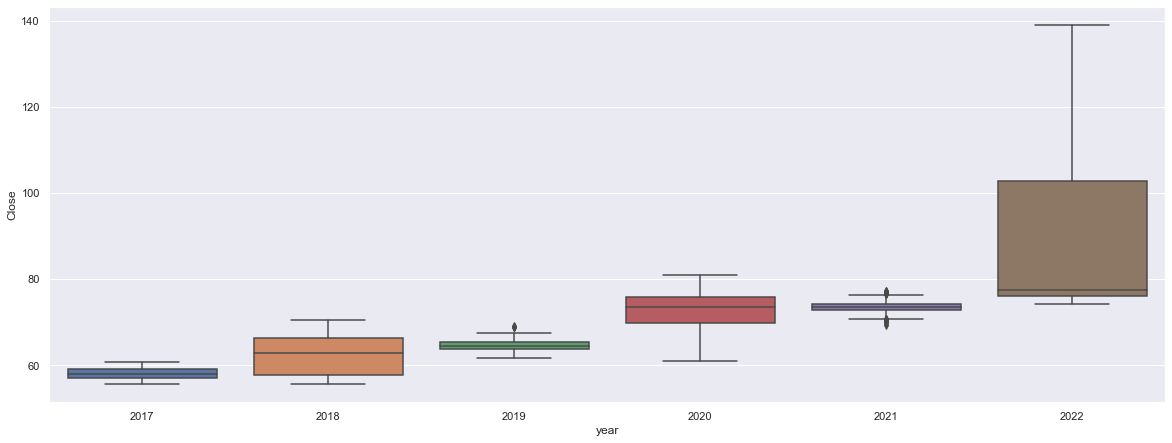

In [12]:
sns.boxplot(x='year', y='Close', data=df_usd)

In this plot we can see how volatility were pair of USD/RUB:<br>
In 2020 because of pandemic and huge volatility in 2022 because of War

<AxesSubplot:xlabel='month', ylabel='Close'>

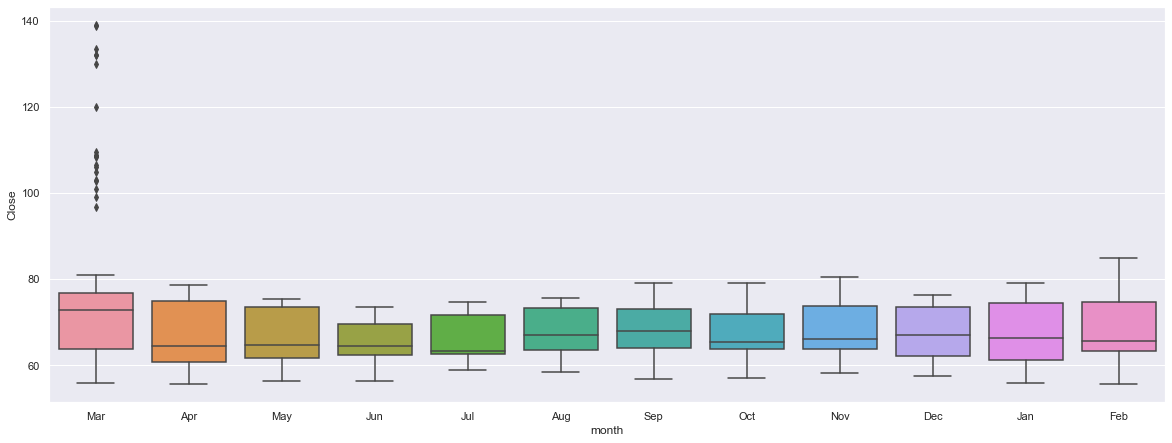

In [13]:
sns.boxplot(x='month', y='Close', data=df_usd)

We can notice there are outliers in March and volatility in Feb mostly because of war impacte and between Feb and March pair of USD/RUB changed almost two times. And also I could say that in second quater there little volatility and not high mean(median) value because most Russian companies include Oil exporters starting sell their revenue which in dollars to preparing pay dividends.  

Text(0.5, 1.0, 'USD/RUB')

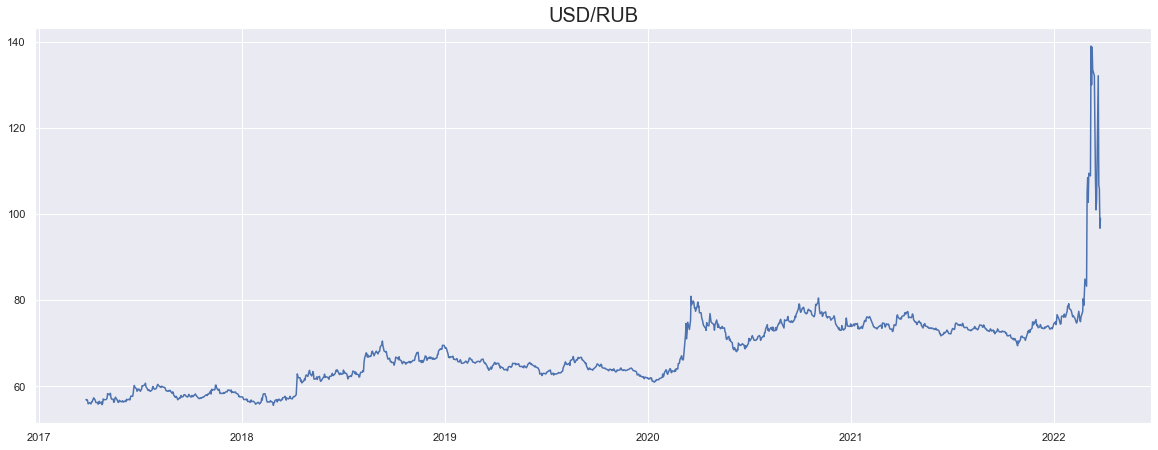

In [14]:
plt.plot(df_usd.Close)
plt.title('USD/RUB', size=20)

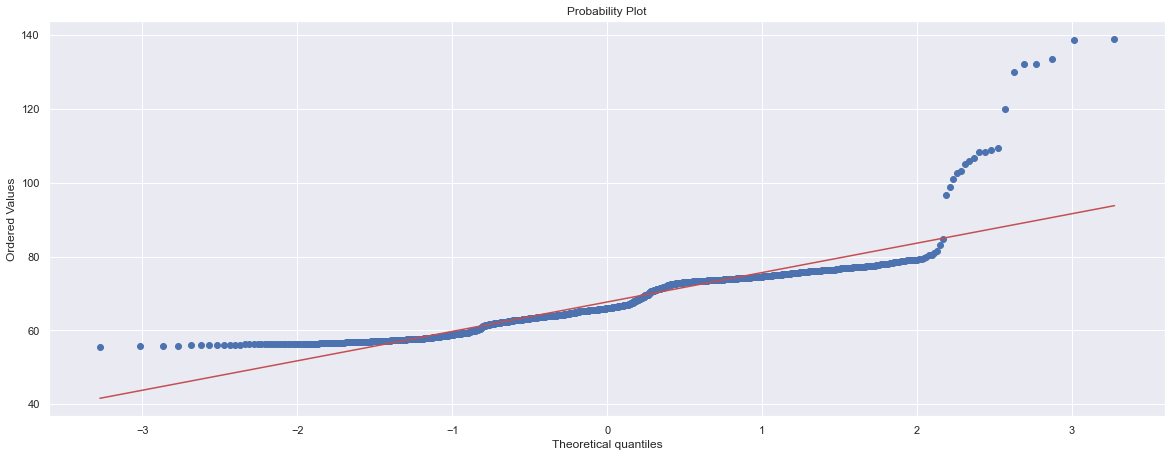

In [15]:
# QQPLot show us is our dataset normally distributed
from scipy import stats
import pylab

# We can see that our data is not normally distributed
stats.probplot(df_usd.Close, plot=pylab)
pylab.show()

### 3. Season, trend, autocorrelation, stationarity

#### Seasonality

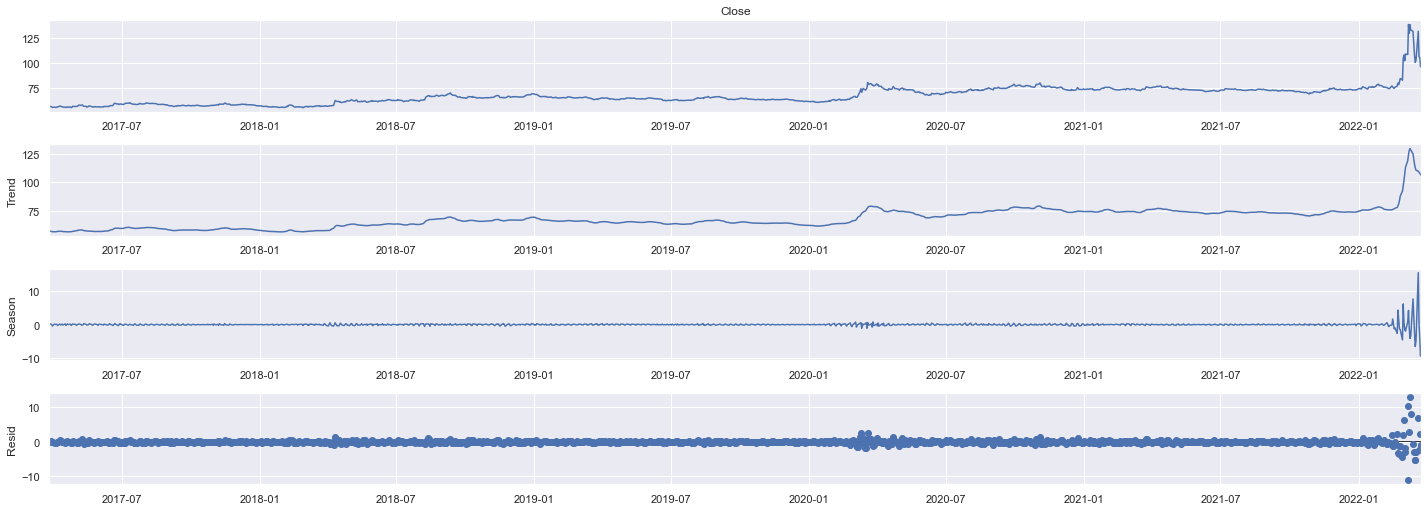

In [16]:
res = STL(df_usd.Close).fit()
res.plot()
plt.show()

Here we can see, there no any seasonality and distincly trend in our daily dataset. <br>
There is some noise in residual as we know its impacted by covid and war

In [17]:
# Here are some graph
# If we had trend and seasonality rolmean and rolstd could show us
rolmean = df_usd.Close.rolling(window=12).mean()
rolstd = df_usd.Close.rolling(window=12).std()

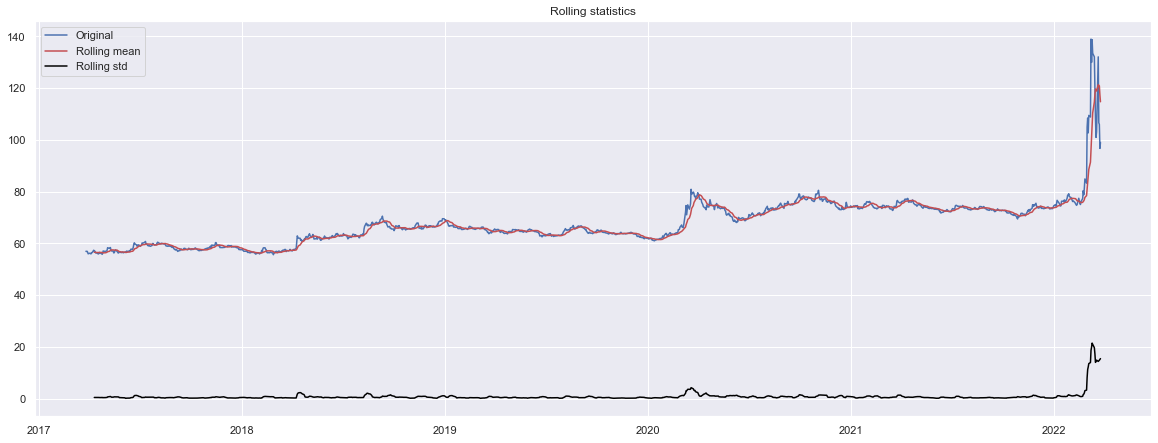

In [18]:
plt.plot(df_usd.Close, label='Original')
plt.plot(rolmean, color='r', label='Rolling mean')
plt.plot(rolstd, color='black', label='Rolling std')
plt.title('Rolling statistics')
plt.legend(loc='best')

#### Stationary

In [19]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(df):
    result = adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [20]:
# Our data is non stationary
adfuller_test(df_usd.Close)

ADF Test Statistic : 0.840396744466359
p-value : 0.9922610404501884
#Lags Used : 23
Number of Observations Used : 1281
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


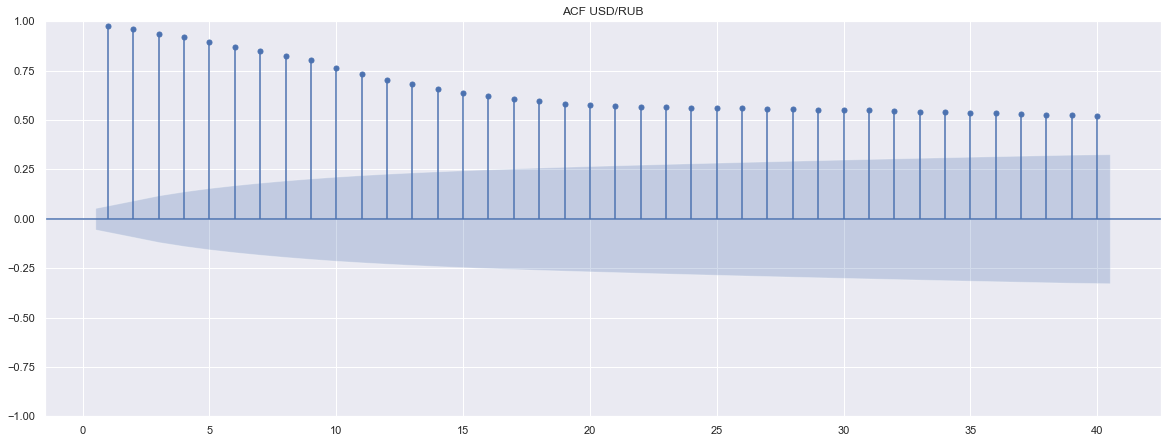

In [21]:
plot_acf(df_usd.Close, lags=40 , zero=False)
plt.title('ACF USD/RUB')
plt.show()

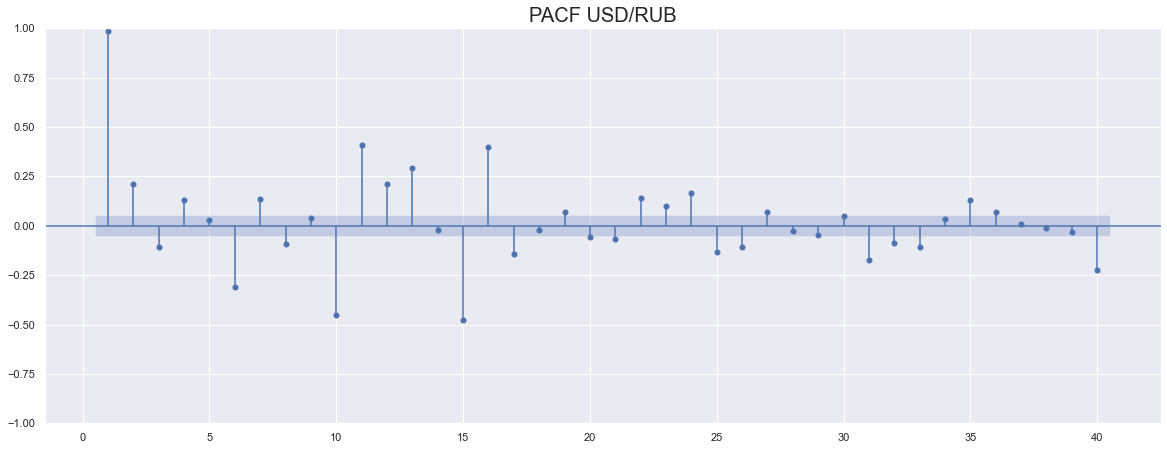

In [22]:
# Direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(df_usd.Close, lags=40, zero=False, method=('ols'))
plt.title('PACF USD/RUB', size=20)
plt.show()

### 4. Construct models with different time series models

In [23]:
# Calculating how our model actually predicting good
# Is the error of predicted model within one standard error away from the mean
def statistics(test_, pred):
    print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(test_, pred)),2))
    print('MAPE of between predicted model and test: ', round(mean_absolute_percentage_error(test_, pred),2))
    print(f'Mean: {df_usd.Close.mean()} \nStandard deviation: {np.sqrt(df_usd.Close.var())}')

##### a) Simple linear model

In [24]:
# train_test_split 80/20
X = np.arange(0,len(df_usd.Close), 1)

X_test = X[1043:].reshape(-1,1)
X_train = X[:1043].reshape(-1,1)
y_train = df_usd.Close[:1043]
y_test = df_usd.Close[1043:]

X_forecast = X.reshape(-1,1)

In [25]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [26]:
lin_regression = LinearRegression().fit(X_train, y_train)
model_line = lin_regression.predict(X_test)

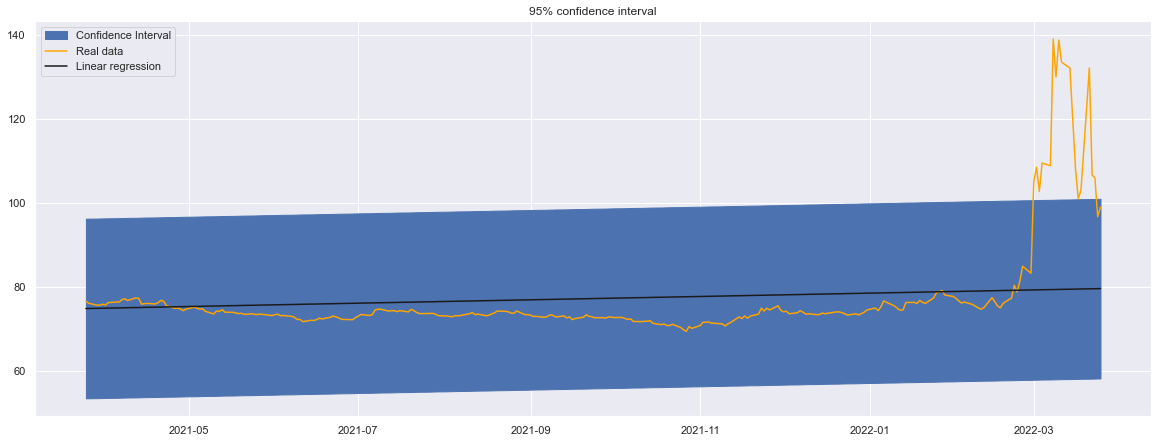

In [27]:
lower_vet = []
upper_vet = []

for i in model_line:
    lower, prediction, upper =  get_prediction_interval(i, y_test, model_line)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(y_test.index,upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(y_test.index,y_test,color='orange',label='Real data')
plt.plot(y_test.index,model_line,'k',label='Linear regression')
plt.title('95% confidence interval')
plt.legend(loc='best')
plt.show()

In [28]:
statistics(model_line, y_test)

RMSE of between predicted model and test:  10.86
MAPE of between predicted model and test:  0.07
Mean: 67.71992540076629 
Standard deviation: 8.91945932978687


In [29]:
#Forecast 
lin_regression = LinearRegression().fit(X_forecast, df_usd.Close)
next_5 = np.arange(len(X_forecast),len(X_forecast)+5).reshape(-1,1)
next_10 = np.arange(len(X_forecast),len(X_forecast)+10).reshape(-1,1)
next_15 = np.arange(len(X_forecast),len(X_forecast)+15).reshape(-1,1)
model_line_next5 = lin_regression.predict(next_5)
model_line_next10 = lin_regression.predict(next_10)
model_line_next15 = lin_regression.predict(next_15)


C:\Users\User\AppData\Local\Temp/ipykernel_5160/427111968.py:2: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.

C:\Users\User\AppData\Local\Temp/ipykernel_5160/427111968.py:3: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.

C:\Users\User\AppData\Local\Temp/ipykernel_5160/427111968.py:4: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.



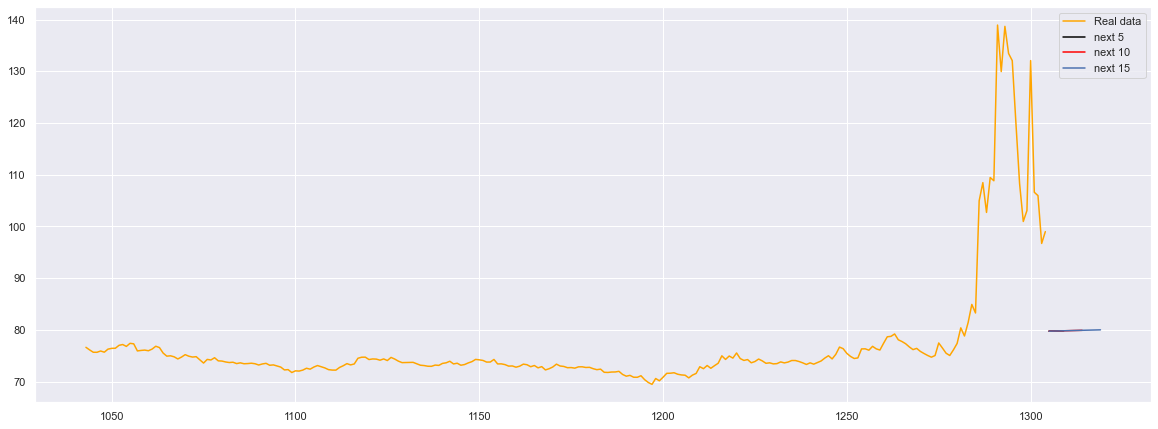

In [30]:
plt.plot(X_test,y_test,color='orange',label='Real data')
plt.plot(next_5, model_line_next5,'k',label='next 5', color='black')
plt.plot(next_10, model_line_next10,'k',label='next 10', color='red')
plt.plot(next_15, model_line_next15,'k',label='next 15', color='b')
plt.legend()
plt.show()

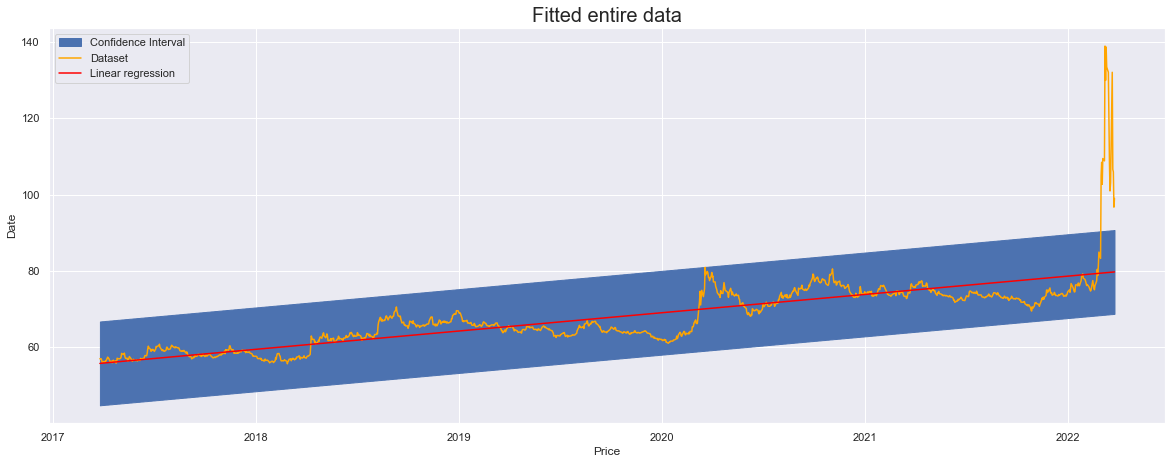

In [31]:
## Plot and save confidence interval of linear regression  - 95%
entire_data_reg = LinearRegression().fit(X_forecast, df_usd.Close)
entire_model_line = entire_data_reg.predict(X_forecast)
lower_vet = []
upper_vet = []

for i in entire_model_line:
    lower, prediction, upper =  get_prediction_interval(i, df_usd.Close, entire_model_line)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(df_usd.index, upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(df_usd.index,df_usd.Close,color='orange',label='Dataset')
plt.plot(df_usd.index,entire_model_line,'red',label='Linear regression')
plt.xlabel('Price')
plt.ylabel('Date')
plt.title('Fitted entire data', size=20)
plt.legend()
plt.show()

#### 4. Exponential Smoothing

In [32]:
# Spliting data into test and train datasets
size = int(len(df_usd.Close)*0.8)
train, test = df_usd.Close[0:size], df_usd.Close[size: len(df_usd.Close)]

#Setting start and end dates
start_date = '2021-03-26'
end_date = '2022-03-25'

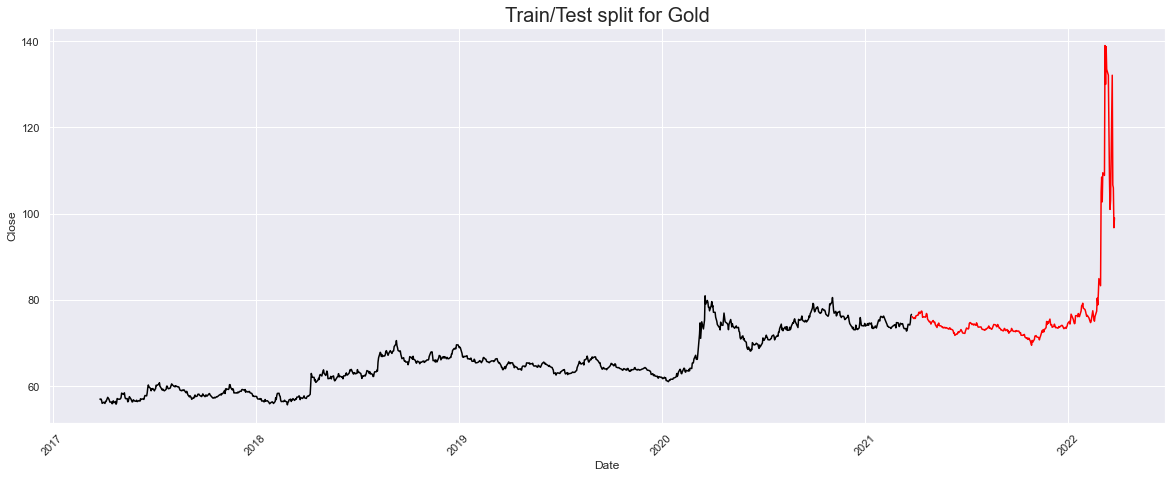

In [33]:
# Plot our splitted data
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gold", size=20)
plt.show()

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing

In [35]:
exp_model = ExponentialSmoothing (
    train
).fit()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [36]:
exp_predict = exp_model.predict(start=start_date, end=end_date)

261

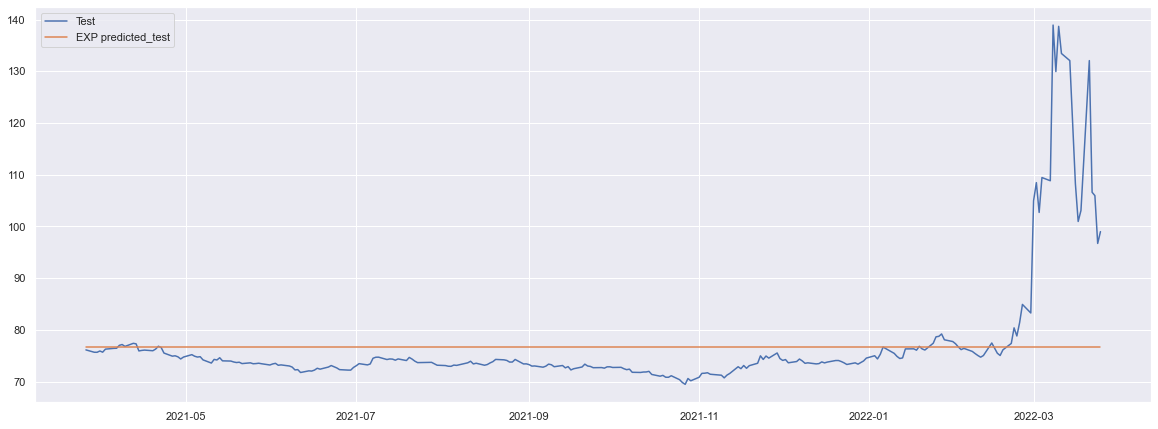

In [37]:
#plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(exp_predict, label='EXP predicted_test')
plt.legend(loc='best')
len(exp_predict)

In [38]:
statistics(test, exp_predict)

RMSE of between predicted model and test:  11.42
MAPE of between predicted model and test:  0.06
Mean: 67.71992540076629 
Standard deviation: 8.91945932978687


In [39]:
exp_model_prediction=ExponentialSmoothing (
    df_usd.Close
).fit()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [40]:
exp_next_5 = exp_model_prediction.forecast(5)
exp_next_10 = exp_model_prediction.forecast(10)
exp_next_15 = exp_model_prediction.forecast(15)

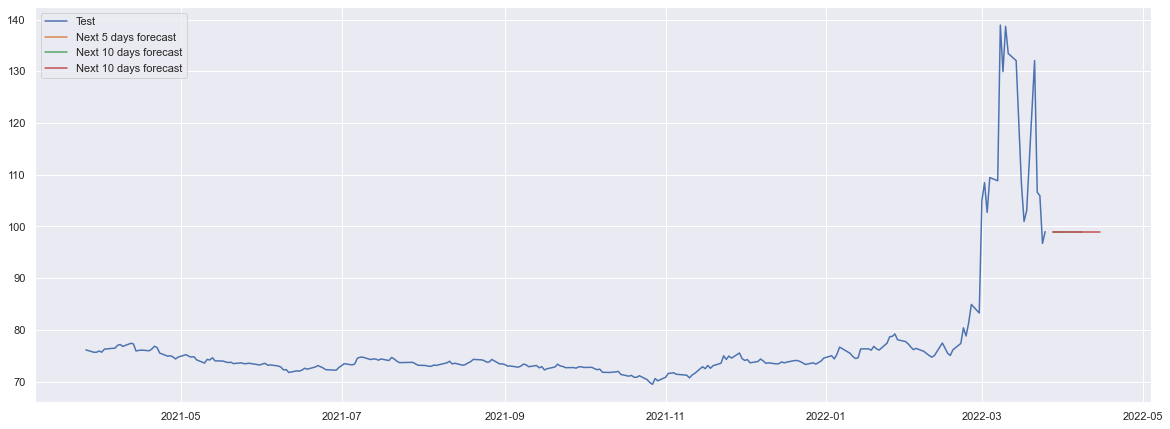

In [41]:
plt.plot(test, label='Test')
plt.plot(exp_next_5, label='Next 5 days forecast')
plt.plot(exp_next_10, label='Next 10 days forecast')
plt.plot(exp_next_15, label='Next 10 days forecast')
plt.legend(loc='best')

#### c) Autoregression (AR)

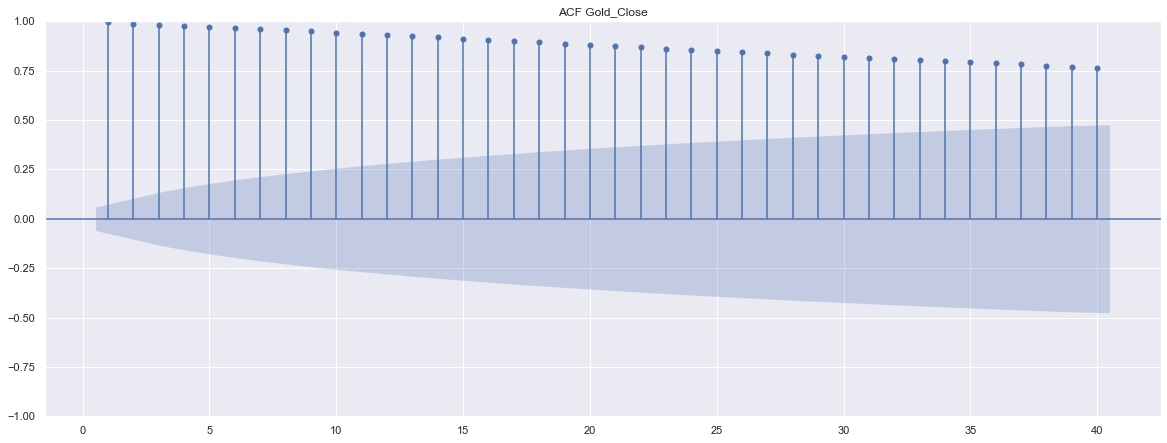

In [42]:
plot_acf(train, lags=40 , zero=False)
plt.title('ACF Gold_Close')
plt.show()

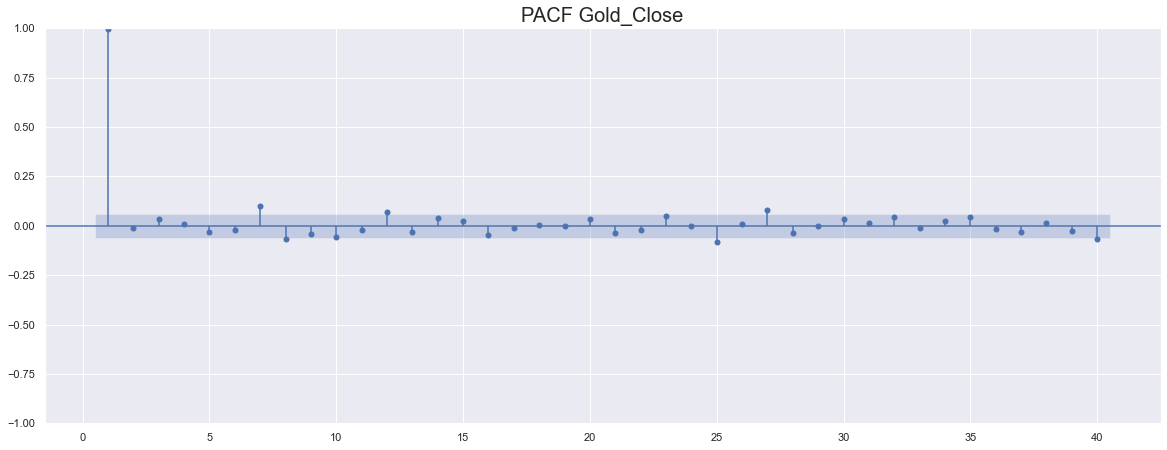

In [43]:
# To find a direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(train, lags=40, zero=False, method=('ols'))
plt.title('PACF Gold_Close', size=20)
plt.show()

In [44]:
# AR model
from statsmodels.tsa.ar_model import AutoReg

In [45]:
# Based on LLR test choose the lag=7, when we get p<0.05 and greater log-likelihood
# Last lag value not be significantly different from 0
model_ar = AutoReg(train, 7)
results_ar = model_ar.fit()
results_ar.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1044
Model:                     AutoReg(7)   Log Likelihood                -870.975
Method:               Conditional MLE   S.D. of innovations              0.560
Date:                Thu, 28 Apr 2022   AIC                           1759.949
Time:                        21:35:00   BIC                           1804.446
Sample:                    04-05-2017   HQIC                          1776.831
                         - 03-25-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2362      0.183      1.289      0.197      -0.123       0.595
Close.L1       1.0123      0.031     32.764      0.000       0.952       1.073
Close.L2      -0.0461      0.044     -1.050      0.294      -0.132       0.040
Close.L3       0.0187      0.044      0.426      0.670      -0.067       0.105
Close.L4       0.0392      0.044      0.892      0.372      -0.047       0.125
Close.L5      -0.0056      0.044     -0.128      0.898      -0.092       0.081
Close.L6      -0.1226      0.044     -2.786      0.005      -0.209      -0.036
Close.L7       0.1007      0.031      3.244      0.001       0.040       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2674           -0.7304j            1.4628           -0.4168
AR.2           -1.2674           +0.7304j            1.4628            0.4168
AR.3            0.0462           -1.4170j            1.4177           -0.2448
AR.4            0.0462           +1.4170j            1.4177            0.2448
AR.5            1.0031           -0.0000j            1.0031           -0.0000
AR.6            1.3280           -0.7333j            1.5171           -0.0803
AR.7            1.3280           +0.7333j            1.5171            0.0803
-----------------------------------------------------------------------------
"""

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



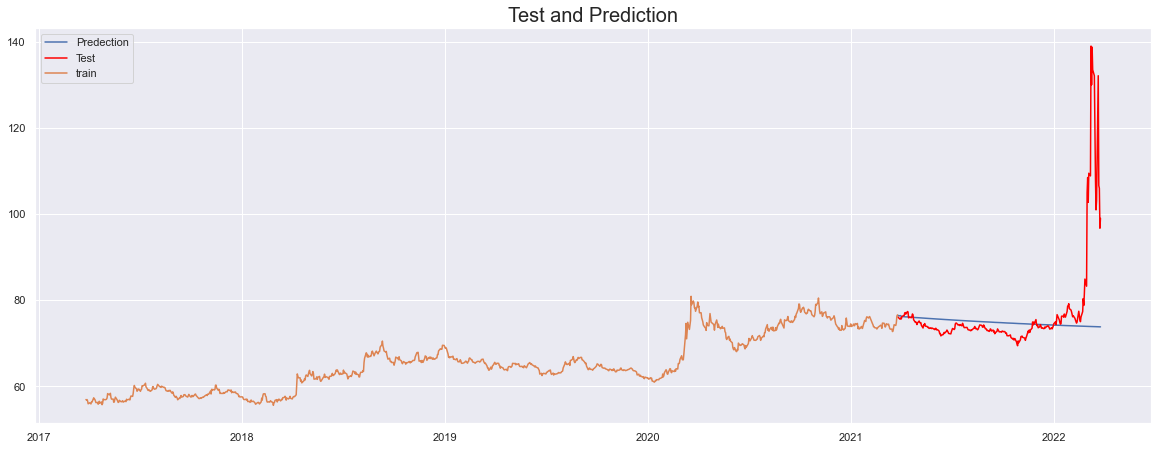

In [46]:
ar_resulst_model = results_ar.predict(start=start_date, end=end_date)
plt.plot(ar_resulst_model, label='Predection')
plt.plot(test, color='red', label='Test')
plt.plot(train, label='train')
plt.title('Test and Prediction', size=20)
plt.legend(loc='best')

In [47]:
statistics(test, ar_resulst_model)

RMSE of between predicted model and test:  11.9
MAPE of between predicted model and test:  0.05
Mean: 67.71992540076629 
Standard deviation: 8.91945932978687


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



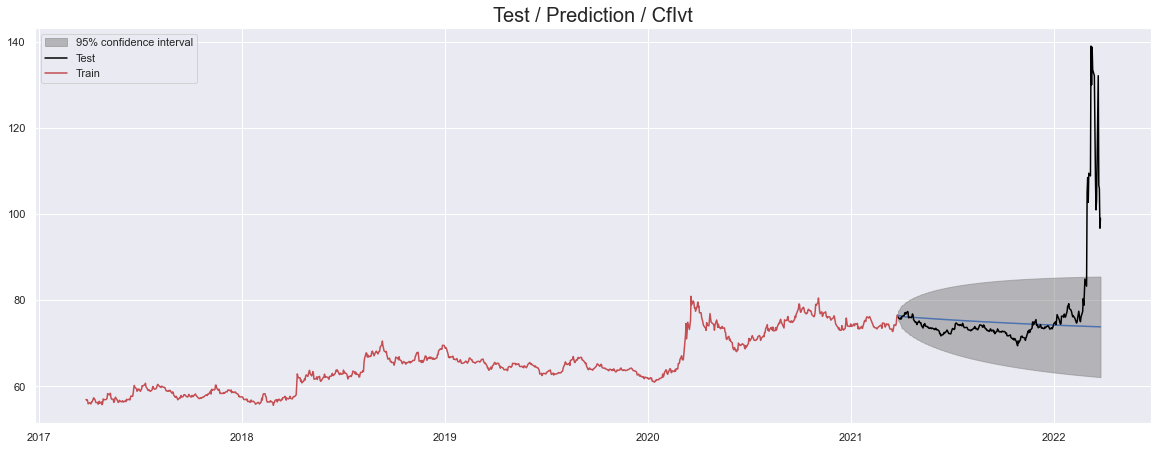

In [48]:
results_ar.plot_predict(1043,1304)
plt.plot(test, color='black', label='Test')
plt.plot(train, color='r', label='Train')
plt.title('Test / Prediction / CfIvt', size=20)
plt.legend(loc='best')

In [49]:
# Forecast
model_ar_forecast = AutoReg(df_usd.Close, 8)
results_ar_results = model_ar_forecast.fit()
results_ar_results.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1305
Model:                     AutoReg(8)   Log Likelihood               -2467.295
Method:               Conditional MLE   S.D. of innovations              1.622
Date:                Thu, 28 Apr 2022   AIC                           4954.590
Time:                        21:35:01   BIC                           5006.268
Sample:                    04-06-2017   HQIC                          4973.982
                         - 03-25-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9972      0.369      2.701      0.007       0.274       1.721
Close.L1       0.8462      0.028     30.388      0.000       0.792       0.901
Close.L2       0.2361      0.036      6.527      0.000       0.165       0.307
Close.L3      -0.2614      0.036     -7.320      0.000      -0.331      -0.191
Close.L4       0.1859      0.037      4.987      0.000       0.113       0.259
Close.L5       0.2552      0.048      5.329      0.000       0.161       0.349
Close.L6      -0.4102      0.047     -8.642      0.000      -0.503      -0.317
Close.L7       0.2289      0.050      4.543      0.000       0.130       0.328
Close.L8      -0.0951      0.037     -2.564      0.010      -0.168      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9949           -0.4953j            1.1114           -0.4265
AR.2           -0.9949           +0.4953j            1.1114            0.4265
AR.3            1.0155           -0.0000j            1.0155           -0.0000
AR.4            1.3693           -0.0000j            1.3693           -0.0000
AR.5            0.1916           -1.4380j            1.4507           -0.2289
AR.6            0.1916           +1.4380j            1.4507            0.2289
AR.7            0.8149           -1.4987j            1.7059           -0.1707
AR.8            0.8149           +1.4987j            1.7059            0.1707
-----------------------------------------------------------------------------
"""

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



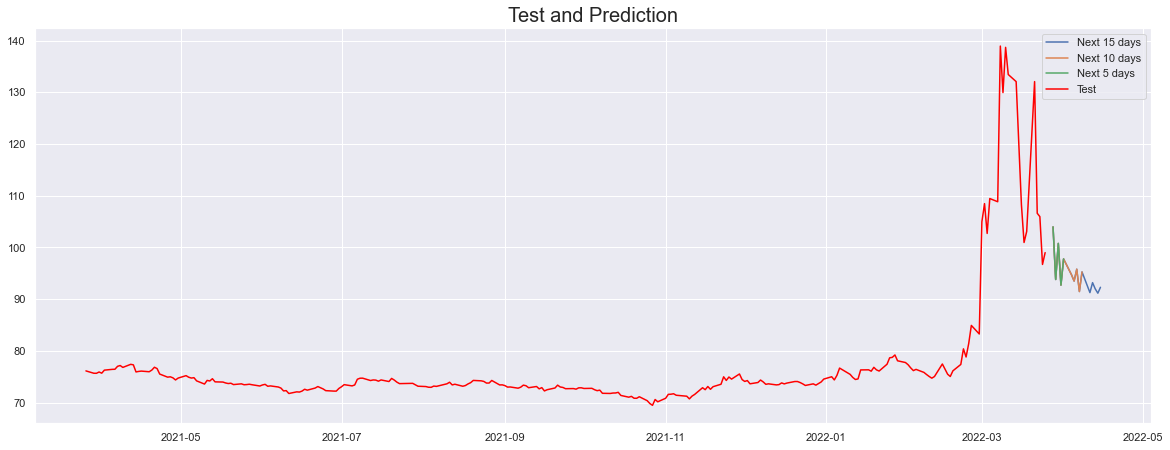

In [50]:
plt.plot(results_ar_results.forecast(15), label='Next 15 days')
plt.plot(results_ar_results.forecast(10), label='Next 10 days')
plt.plot(results_ar_results.forecast(5), label='Next 5 days')
plt.plot(test, color='red', label='Test')
plt.title('Test and Prediction', size=20)
plt.legend(loc='best')

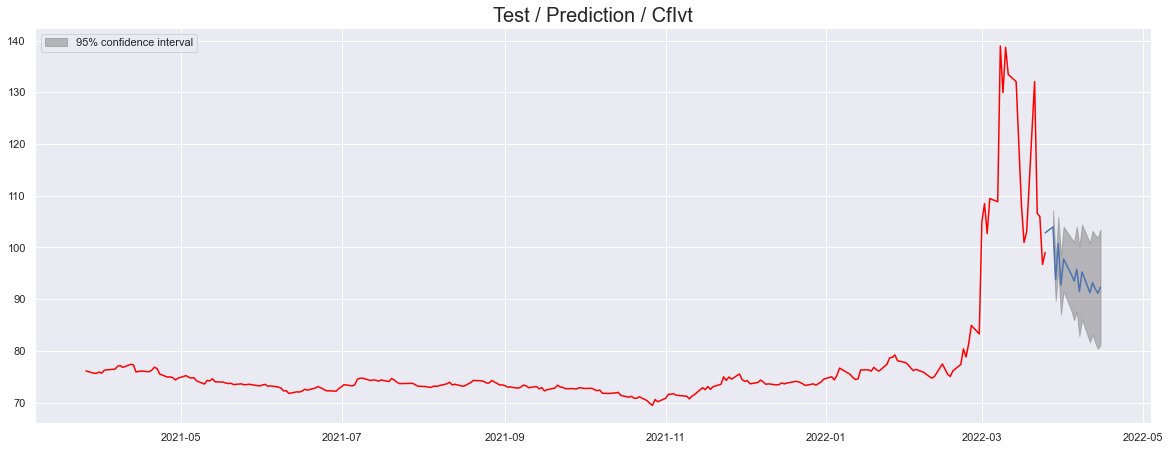

In [51]:
results_ar_results.plot_predict(1304,1319)
plt.plot(test, color='red')
plt.title('Test / Prediction / CfIvt', size=20);

#### d) Moving Average (MA)

In [52]:
# We know, that our data is not stationary that will impact to MA model 
# which predicting non stationary data porly
# We'll use returs inplace Close price
df_usd['returns'] = df_usd.Close.pct_change(1).mul(100)

df_usd = df_usd[1:]

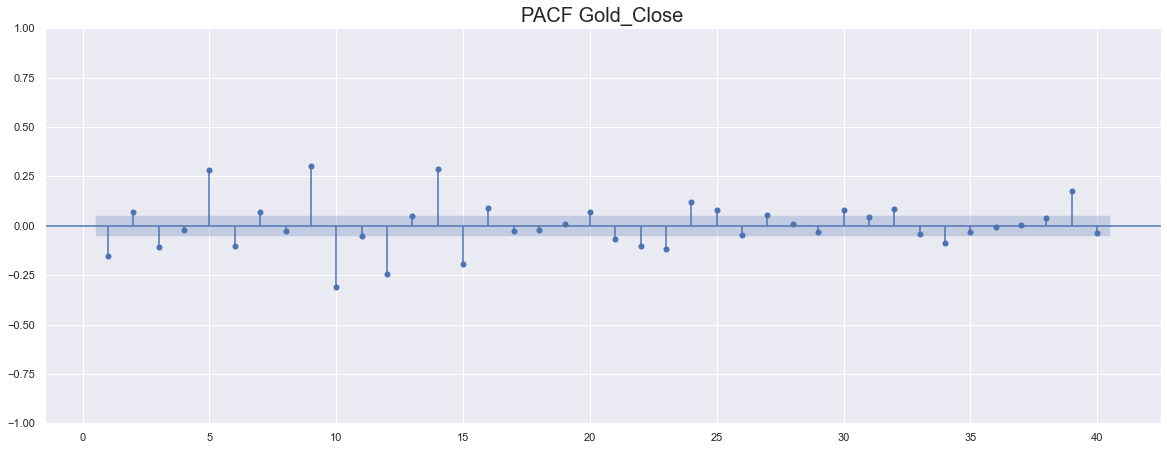

In [53]:
# To find a direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(df_usd.returns, lags=40, zero=False, method=('ols'))
plt.title('PACF Gold_Close', size=20)
plt.show()

In [54]:
# Now we get stationary data
adfuller_test(df_usd.returns)

ADF Test Statistic : -6.147014292239072
p-value : 7.72338897788978e-08
#Lags Used : 23
Number of Observations Used : 1280
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [55]:
# Spliting data into test and train datasets
size_s = int(len(df_usd.returns)*0.8)
train_s, test_s = df_usd.returns[0:size_s], df_usd.returns[size_s: len(df_usd.returns)]

In [56]:
model_ret_ma_1 = ARIMA(train_s, order=(0,0,4))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1043
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1276.592
Date:                Thu, 28 Apr 2022   AIC                           2565.183
Time:                        21:35:04   BIC                           2594.882
Sample:                    03-28-2017   HQIC                          2576.448
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.030      1.050      0.294      -0.027       0.091
ma.L1          0.0243      0.016      1.538      0.124      -0.007       0.055
ma.L2         -0.0248      0.016     -1.506      0.132      -0.057       0.007
ma.L3         -0.0214      0.019     -1.102      0.270      -0.059       0.017
ma.L4          0.0221      0.020      1.089      0.276      -0.018       0.062
sigma2         0.6771      0.013     52.442      0.000       0.652       0.702
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6749.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

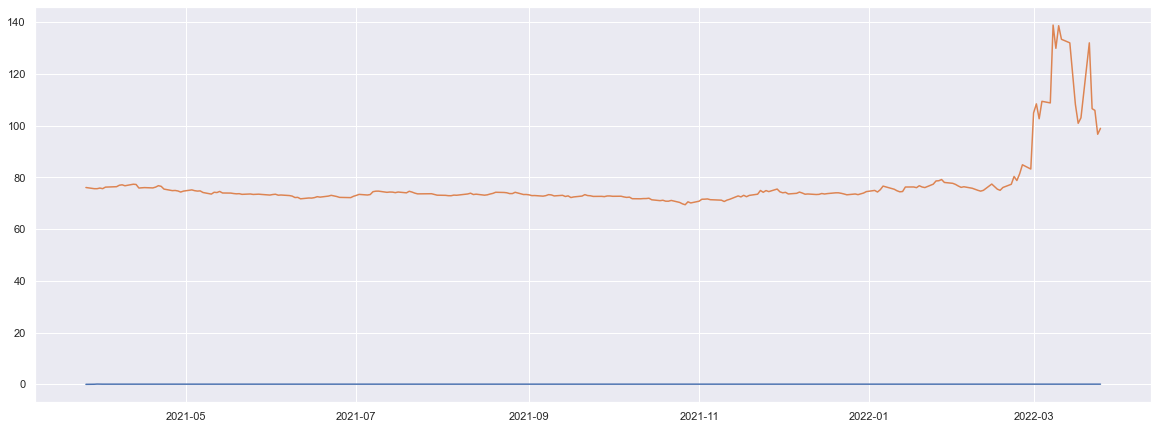

In [57]:
ret_results = results_ret_ma_1.predict(start=start_date, end=end_date)
plt.plot(ret_results)
plt.plot(test)

#### e) Autoregressive Moving Average (ARMA)

In [58]:
arma_model = ARIMA(train, order=(6,0,3))
arma_model_results = arma_model.fit()
arma_model_results.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameter

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1044
Model:                 ARIMA(6, 0, 3)   Log Likelihood                -877.000
Date:                Thu, 28 Apr 2022   AIC                           1776.000
Time:                        21:35:07   BIC                           1830.459
Sample:                    03-27-2017   HQIC                          1796.655
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.4953    161.870      0.405      0.686    -251.764     382.755
ar.L1          0.0818      0.220      0.372      0.710      -0.349       0.513
ar.L2         -0.1276      0.181     -0.706      0.480      -0.482       0.226
ar.L3          0.2677      0.187      1.432      0.152      -0.099       0.634
ar.L4          0.7370      0.210      3.506      0.000       0.325       1.149
ar.L5          0.0649      0.021      3.074      0.002       0.024       0.106
ar.L6         -0.0243      0.023     -1.049      0.294      -0.070       0.021
ma.L1          0.9080      0.219      4.140      0.000       0.478       1.338
ma.L2          1.0074      0.055     18.262      0.000       0.899       1.116
ma.L3          0.7249      0.209      3.464      0.001       0.315       1.135
sigma2         0.3213      0.007     48.273      0.000       0.308       0.334
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              8881.50
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

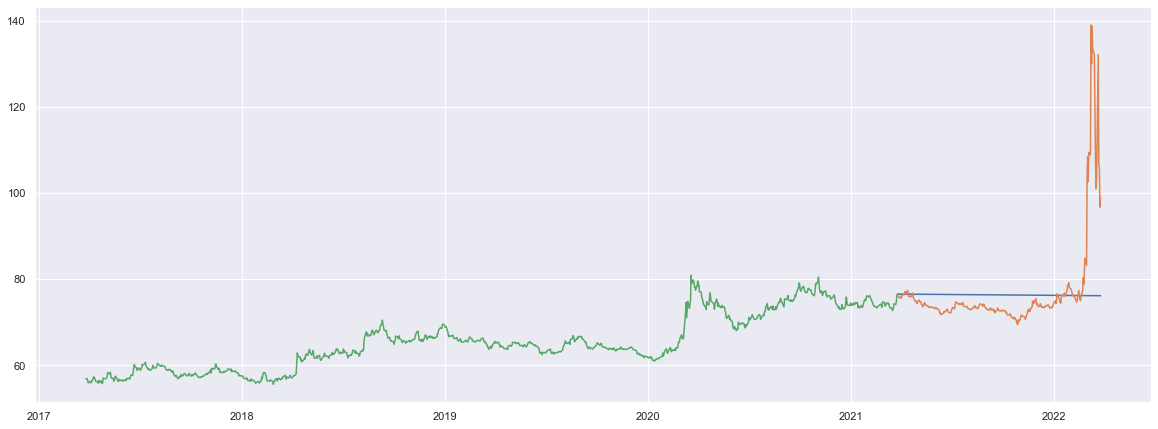

In [59]:
arma_result = arma_model_results.predict(start=start_date, end=end_date)
plt.plot(arma_result)
plt.plot(test)
plt.plot(train)

In [60]:
statistics(test, arma_result)

RMSE of between predicted model and test:  11.48
MAPE of between predicted model and test:  0.06
Mean: 67.7281702814417 
Standard deviation: 8.917905129135836


In [61]:
arma_model_forecst = ARIMA(df_usd.Close, order=(5,0,4))
arma_model_frct = arma_model_forecst.fit()
arma_model_frct.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameter

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1304
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -2397.532
Date:                Thu, 28 Apr 2022   AIC                           4817.064
Time:                        21:35:10   BIC                           4873.969
Sample:                    03-28-2017   HQIC                          4838.412
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.7446    107.146      0.632      0.527    -142.258     277.747
ar.L1         -0.8857      0.017    -52.096      0.000      -0.919      -0.852
ar.L2         -0.0418      0.016     -2.643      0.008      -0.073      -0.011
ar.L3          0.2379      0.015     15.539      0.000       0.208       0.268
ar.L4          0.8159      0.014     59.368      0.000       0.789       0.843
ar.L5          0.8667      0.018     47.691      0.000       0.831       0.902
ma.L1          1.8583      0.021     86.471      0.000       1.816       1.900
ma.L2          2.0240      0.038     52.721      0.000       1.949       2.099
ma.L3          1.7723      0.032     54.696      0.000       1.709       1.836
ma.L4          0.7448      0.023     31.874      0.000       0.699       0.791
sigma2         2.3303      0.020    115.514      0.000       2.291       2.370
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):            757974.32
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              27.12   Skew:                             3.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       120.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

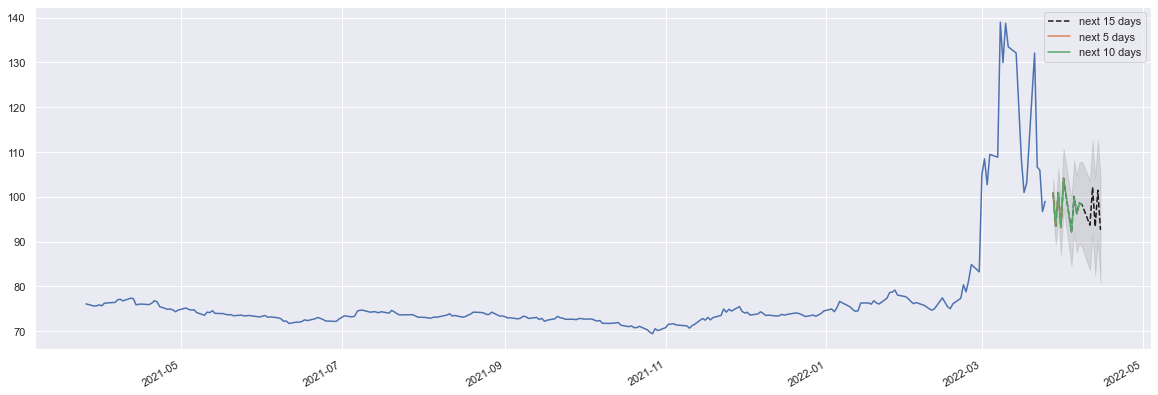

In [62]:
preds_next15 = arma_model_frct.get_forecast(15)
x = preds_next15.summary_frame()
fig, ax = plt.subplots(figsize=(20, 7))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
plt.plot(test)

# Construct the forecasts
x['mean'].plot(ax=ax, style='k--', label='next 15 days')
ax.fill_between(x.index, x['mean_ci_lower'], x['mean_ci_upper'], color='k', alpha=0.1);
plt.plot(arma_model_frct.forecast(5), label='next 5 days')
plt.plot(arma_model_frct.forecast(10), label='next 10 days')
plt.legend(loc='best')

#### f) Autoregressive Integrated Moving Average (ARIMA)

In [63]:
arima_model = ARIMA(train, order=(0,1,0))
arima_model_results = arima_model.fit()
arima_model_results.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1044
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -882.284
Date:                Thu, 28 Apr 2022   AIC                           1766.568
Time:                        21:35:11   BIC                           1771.518
Sample:                    03-27-2017   HQIC                          1768.446
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3179      0.005     68.038      0.000       0.309       0.327
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             10969.55
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

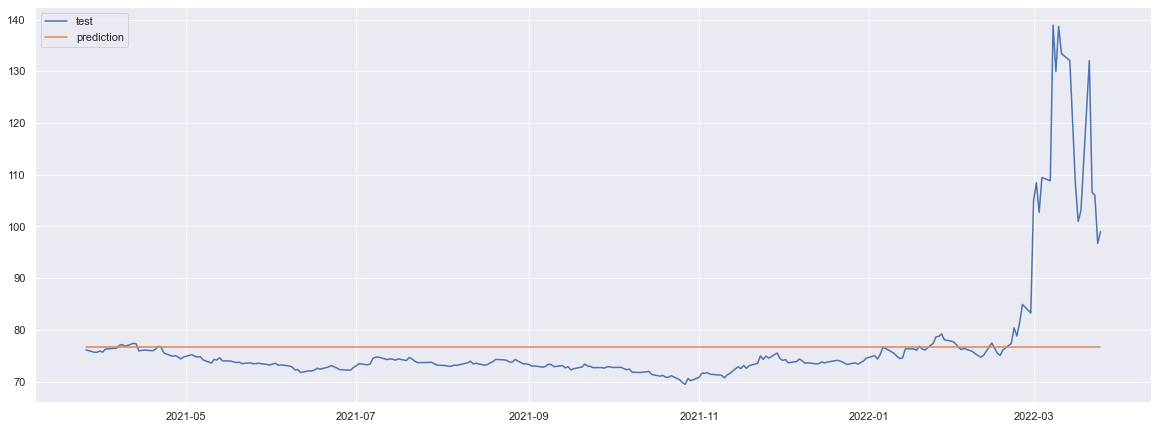

In [64]:
arima_results = arima_model_results.predict(start=start_date, end=end_date)
plt.plot(test, label='test')
plt.plot(arima_results, label='prediction')
plt.legend(loc='best')

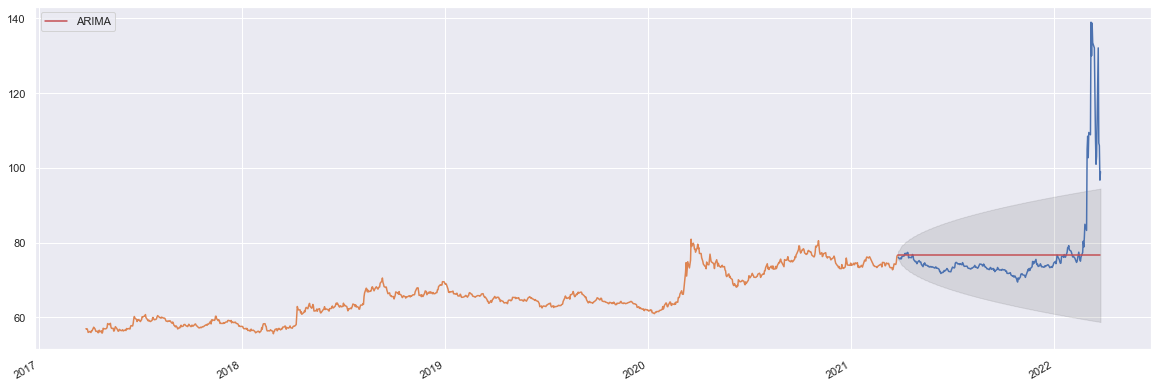

In [65]:
arima_results_invt = arima_model_results.get_forecast(len(test))
arima_forecasted = arima_results_invt.summary_frame()
fig, ax = plt.subplots(figsize=(20, 7))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
plt.plot(test)
plt.plot(train)

# Construct the forecasts
arima_forecasted['mean'].plot(ax=ax, style='r', label='ARIMA')
ax.fill_between(arima_forecasted.index, arima_forecasted['mean_ci_lower'], arima_forecasted['mean_ci_upper'], color='k', alpha=0.1);
plt.legend(loc='best')

In [66]:
statistics(test, arima_results)

RMSE of between predicted model and test:  11.42
MAPE of between predicted model and test:  0.06
Mean: 67.7281702814417 
Standard deviation: 8.917905129135836


In [67]:
# Autoarima tuning (minimizing AIC) gives certain parameters
arima_model_forecast = ARIMA(df_usd.Close, order=(5,1,1))
arima_model_frct = arima_model_forecast.fit()
arima_model_frct.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1304
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -2448.769
Date:                Thu, 28 Apr 2022   AIC                           4911.537
Time:                        21:35:13   BIC                           4947.744
Sample:                    03-28-2017   HQIC                          4925.121
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9188      0.006   -142.917      0.000      -0.931      -0.906
ar.L2         -0.0388      0.008     -4.780      0.000      -0.055      -0.023
ar.L3         -0.0983      0.008    -12.248      0.000      -0.114      -0.083
ar.L4         -0.1057      0.010    -10.248      0.000      -0.126      -0.085
ar.L5          0.2124      0.008     27.657      0.000       0.197       0.227
ma.L1          0.8330      0.006    143.670      0.000       0.822       0.844
sigma2         2.5086      0.015    165.791      0.000       2.479       2.538
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            827069.60
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              29.71   Skew:                             3.97
Prob(H) (two-sided):                  0.00   Kurtosis:                       126.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

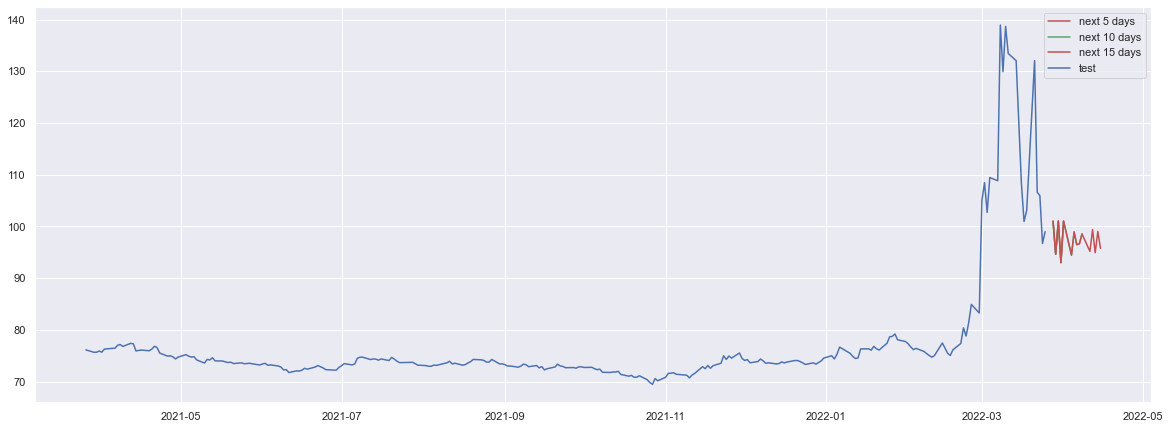

In [68]:
plt.plot(arima_model_frct.forecast(5),color='r', label='next 5 days')
plt.plot(arima_model_frct.forecast(10), color='g', label='next 10 days')
plt.plot(arima_model_frct.forecast(15), color='r', label='next 15 days')
plt.plot(test, label='test')
plt.legend(loc='best')

#### g) Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarima_model = SARIMAX (
        train,
        order=(0,1,0),
        seasonal_order=(2,0,0,12)
)
                
sarima_result = sarima_model.fit()
sarima_result.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1044
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -876.708
Date:                            Thu, 28 Apr 2022   AIC                           1759.416
Time:                                    21:35:14   BIC                           1774.265
Sample:                                03-27-2017   HQIC                          1765.048
                                     - 03-25-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0378      0.025      1.497      0.134      -0.012       0.087
ar.S.L24       0.0949      0.025      3.844      0.000       0.047       0.143
sigma2         0.3144      0.005     65.260      0.000       0.305       0.324
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):             11419.50
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               3.27   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

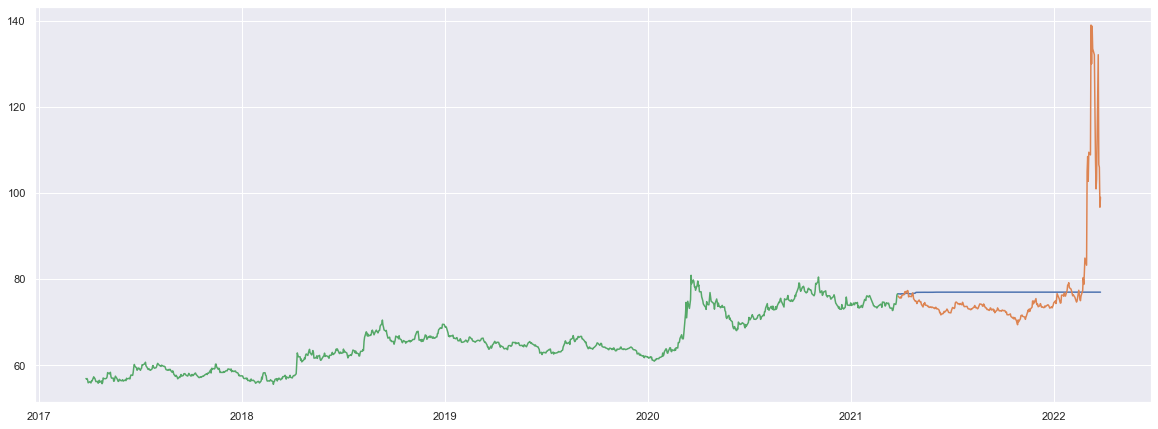

In [70]:

sarima_result_prediction = sarima_result.predict(start=start_date, end=end_date)
plt.plot(sarima_result_prediction)
plt.plot(test)
plt.plot(train)


#### Summary
Linear regression shows good results except some outliers, because our dataset lineary describe better, except last month which I dropped below
So, if I want build prediction models for usd/rub I'll choose LR, Multiple linear regression, ARIMA, ARMA, AR models, until I'll test another LSTM, XGBoost, Prophet. 

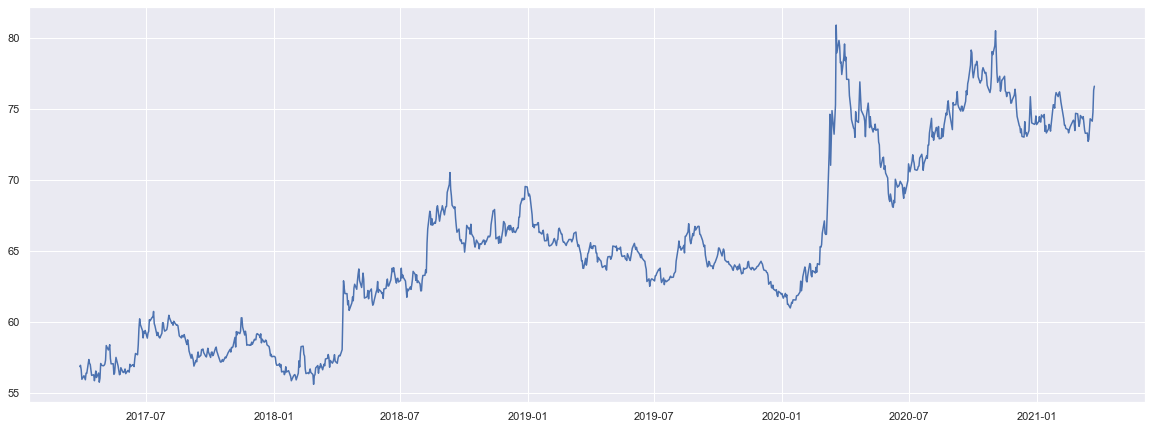

In [75]:
plt.plot(df_usd.Close[:1043])